<a href="https://colab.research.google.com/github/DsMikeMelo/Sales-Prediction-Previsao-de-Vendas/blob/main/Cluster_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 IMPORT

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import inflection
import datetime as datetime
import xgboost as xgb
import random
import warnings
import sklearn
import boruta

from scipy import stats as ss
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler , MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

In [ ]:
dataset ='/content/Spotfy.csv'

In [ ]:
df = pd.read_csv( dataset, low_memory=False )


# 1 Data description

In [ ]:
df.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [ ]:
#checking lines and columns
df.shape

(300, 18)

In [ ]:
#checking types
df.dtypes

Unnamed: 0            int64
artist_name          object
track_name           object
track_id             object
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

In [ ]:
#cheking NA
df.isnull().sum()

Unnamed: 0          0
artist_name         0
track_name          0
track_id            0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [ ]:
#splitting two dataframes in numerical and nonnumerical6
num_attributes = df.select_dtypes( include=['int64', 'float64'] )
num_attributes = num_attributes.drop( 'Unnamed: 0', axis=1 )

cat_attributes = df.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

In [ ]:
#Check - point
df1 = df

#2 SCALLING

In [ ]:
# putting the data in the same scale
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_attributes))
scaled.columns = num_attributes.columns

scaled.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.86,0.819364,0.506928,0.454545,0.545212,0.0,0.038116,0.252951,0.000011,0.168483,0.903137,0.690948,0.086668,0.75
1,0.85,0.578035,0.729792,0.363636,0.706076,1.0,0.035657,0.059682,0.000000,0.975086,0.657677,0.508160,0.075697,0.75
2,0.85,0.660405,0.841801,0.909091,0.780177,0.0,0.062462,0.428185,0.000000,0.095816,0.870116,0.658797,0.161742,0.75
3,0.84,0.553468,0.789838,0.000000,0.637684,0.0,0.174966,0.074438,0.000000,0.374027,0.591635,0.902084,0.178135,0.75
4,0.84,0.380058,0.876443,1.000000,0.787439,1.0,0.070577,0.243728,0.000000,0.325236,0.719318,0.677181,0.150162,0.75


#3 FINDING THE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

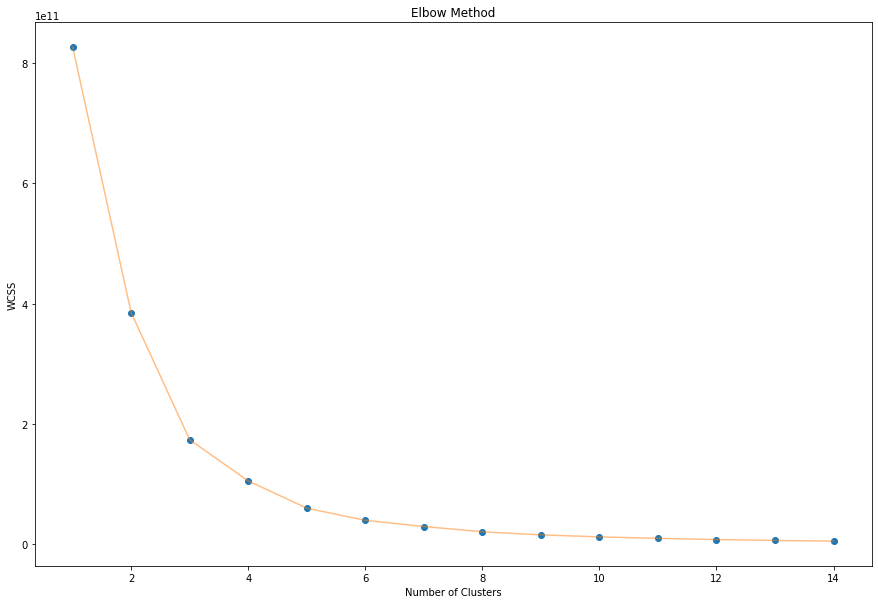

In [ ]:
# testing original data
wcss = []
for i in range(1,15):
  # instancing the model
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  # dando fit nos dados
  kmeans.fit(num_attributes)
  # saving the model in the list
  wcss.append(kmeans.inertia_)

# Plotting the Elbow Method  
plt.figure(figsize=(15,10))
plt.plot(range(1,15), wcss, 'o')
plt.plot(range(1 , 15) , wcss , '-' , alpha = 0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

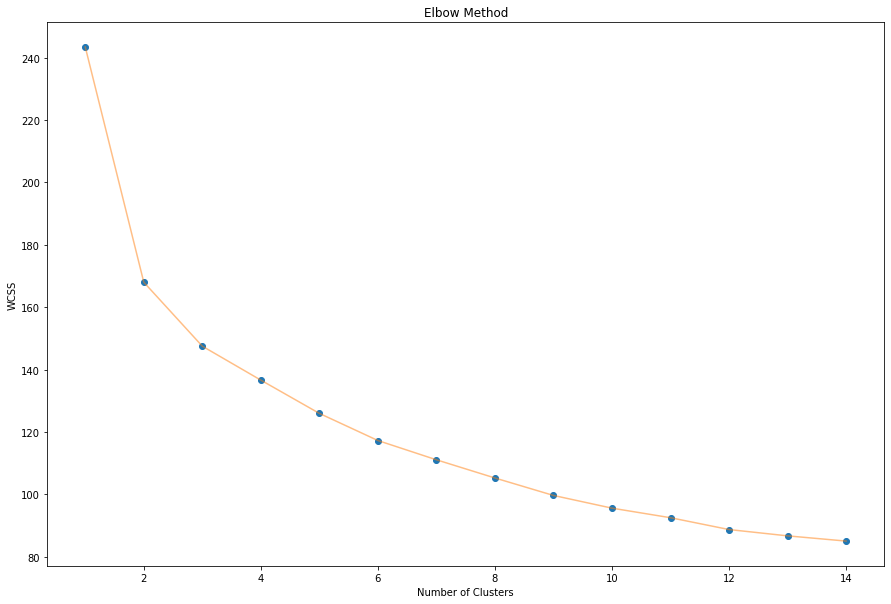

In [ ]:
# Dados Padronizados
wcss = []
for i in range(1,15):
  # instanciando o modelo
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  # dando fit nos dados
  kmeans.fit(scaled)
  # salvando os resultados na lista
  wcss.append(kmeans.inertia_)
  
# plotando o Elbow Method  
plt.figure(figsize=(15,10))
plt.plot(range(1,15), wcss, 'o')
plt.plot(range(1 , 15) , wcss , '-' , alpha = 0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

# 4 - APPLYING THE K-MEANS MODEL

In [ ]:
# instanciando o modelo
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(scaled)

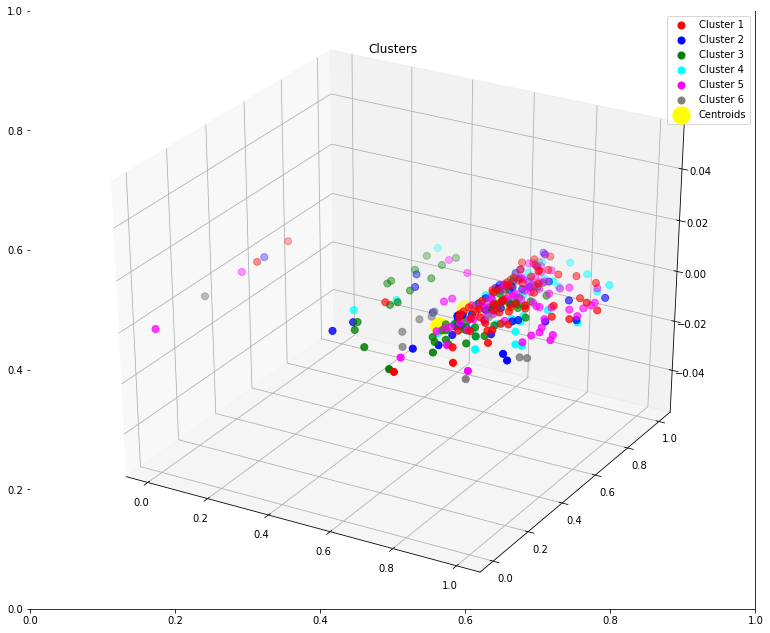

In [ ]:
# visualizando os clusters
fig, ax = plt.subplots(figsize=(13,11))
scaled = scaler.fit_transform(num_attributes)
# definindo a figura em 3 dimensões
ax = fig.add_subplot(111, projection='3d')
# plotando os clusters
plt.scatter(scaled[y_kmeans == 0,0],scaled[y_kmeans == 0,1], s= 50, c= 'red',label= 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1,0], scaled[y_kmeans == 1,1], s= 50, c= 'blue', label= 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2,0], scaled[y_kmeans == 2,1], s= 50, c= 'green', label= 'Cluster 3')
plt.scatter(scaled[y_kmeans == 3,0], scaled[y_kmeans == 3,1], s= 50, c= 'cyan', label= 'Cluster 4')
plt.scatter(scaled[y_kmeans == 4,0], scaled[y_kmeans == 4,1], s= 50, c= 'magenta', label= 'Cluster 5')
plt.scatter(scaled[y_kmeans == 5,0], scaled[y_kmeans == 5,1], s= 50, c= 'gray', label= 'Cluster 6')


# centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
plt.title('Clusters')
plt.legend()
plt.savefig('clusters.png')
plt.show()

In [ ]:
#converting the prediction into the dataframe

kmeans = pd.DataFrame(data=y_kmeans, dtype=int)
kmeans.columns = ['cluster']

# previsões como um df
print(kmeans.shape)
kmeans.head()

(300, 1)


,cluster
0,4
1,2
2,4
3,1
4,0


In [ ]:
df2 = df1

In [ ]:
# concatenando os clusters 
df2 = pd.concat([df2, kmeans], axis=1)

# conferindo os dataframes
print(df.shape)
df.head()

(300, 19)


,Unnamed: 0,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0,Dadá Boladão,Surtada - Remix Brega Funk,5F8ffc8KWKNawllr5WsW0r,86,0.832,0.550,5,-7.026,0,0.0587,0.2490,0.000008,0.182,0.881,154.064,152784,4,4
1,1,Marília Mendonça,Supera - Ao Vivo,3GmJxfnUDrIs1iCfKUELFz,85,0.665,0.743,4,-4.434,1,0.0567,0.0604,0.000000,0.959,0.658,131.573,147748,4,2
2,2,MC Du Black,Gaiola É o Troco,3Uq45ipGutypFPmETfaoaH,85,0.722,0.840,10,-3.240,0,0.0785,0.4200,0.000000,0.112,0.851,150.108,187246,4,4
3,3,Anitta,Some que ele vem atrás,2qD7VoDYcrAPY0cVEfpsR5,84,0.648,0.795,0,-5.536,0,0.1700,0.0748,0.000000,0.380,0.598,180.043,194771,4,1
4,4,Jorge & Mateus,Cheirosa - Ao Vivo,2PWjKmjyTZeDpmOUa3a5da,84,0.528,0.870,11,-3.123,1,0.0851,0.2400,0.000000,0.333,0.714,152.370,181930,4,0


In [ ]:
df2.isnull().sum()

Unnamed: 0          0
artist_name         0
track_name          0
track_id            0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
cluster             0
dtype: int64

In [ ]:
#description
df2.describe()

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,149.500000,72.593333,0.687493,0.690387,5.416667,-5.590880,0.580000,0.130343,0.366675,0.007022,0.348395,0.624141,128.108953,187367.970000,3.993333,2.173333
std,86.746758,15.518291,0.131100,0.179981,3.733119,2.812709,0.494383,0.127546,0.247943,0.060881,0.310920,0.216386,25.543347,52572.133558,0.356435,1.572109
min,0.000000,0.000000,0.265000,0.111000,0.000000,-15.811000,0.000000,0.027700,0.002160,0.000000,0.019700,0.060500,69.047000,113000.000000,1.000000,0.000000
25%,74.750000,69.000000,0.600500,0.564750,2.000000,-6.847500,0.000000,0.046500,0.158750,0.000000,0.102750,0.498000,108.733000,159489.000000,4.000000,1.000000
50%,149.500000,73.000000,0.693500,0.716500,6.000000,-5.261000,1.000000,0.077650,0.339000,0.000000,0.198500,0.656500,128.521000,179082.500000,4.000000,2.000000
75%,224.250000,79.000000,0.783000,0.833500,9.000000,-3.603250,1.000000,0.166250,0.523250,0.000004,0.609750,0.790000,148.496250,203776.250000,4.000000,4.000000
max,299.000000,100.000000,0.957000,0.977000,11.000000,0.302000,1.000000,0.841000,0.978000,0.747000,0.983000,0.969000,192.091000,572039.000000,5.000000,5.000000


In [ ]:
df2['cluster'].value_counts()

4    75
0    63
2    54
1    51
3    46
5    11
Name: cluster, dtype: int64

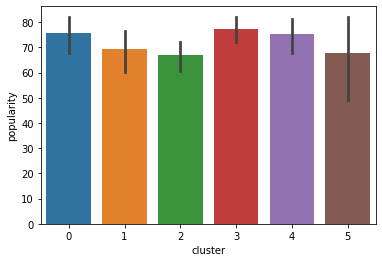

In [ ]:
aux1 = df2[['artist_name','popularity','cluster']].groupby( ['popularity','cluster' ]).sum().reset_index()

sns.barplot( x='cluster', y='popularity', data=aux1 )


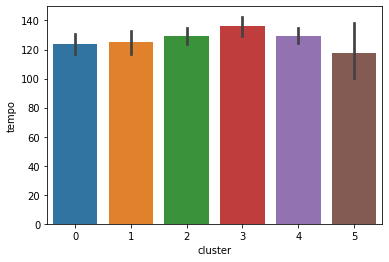

In [ ]:
aux2 = df2[['artist_name','tempo','cluster']].groupby( ['cluster','tempo'] ).sum().reset_index()

sns.barplot( x='cluster', y='tempo', data=aux2 )


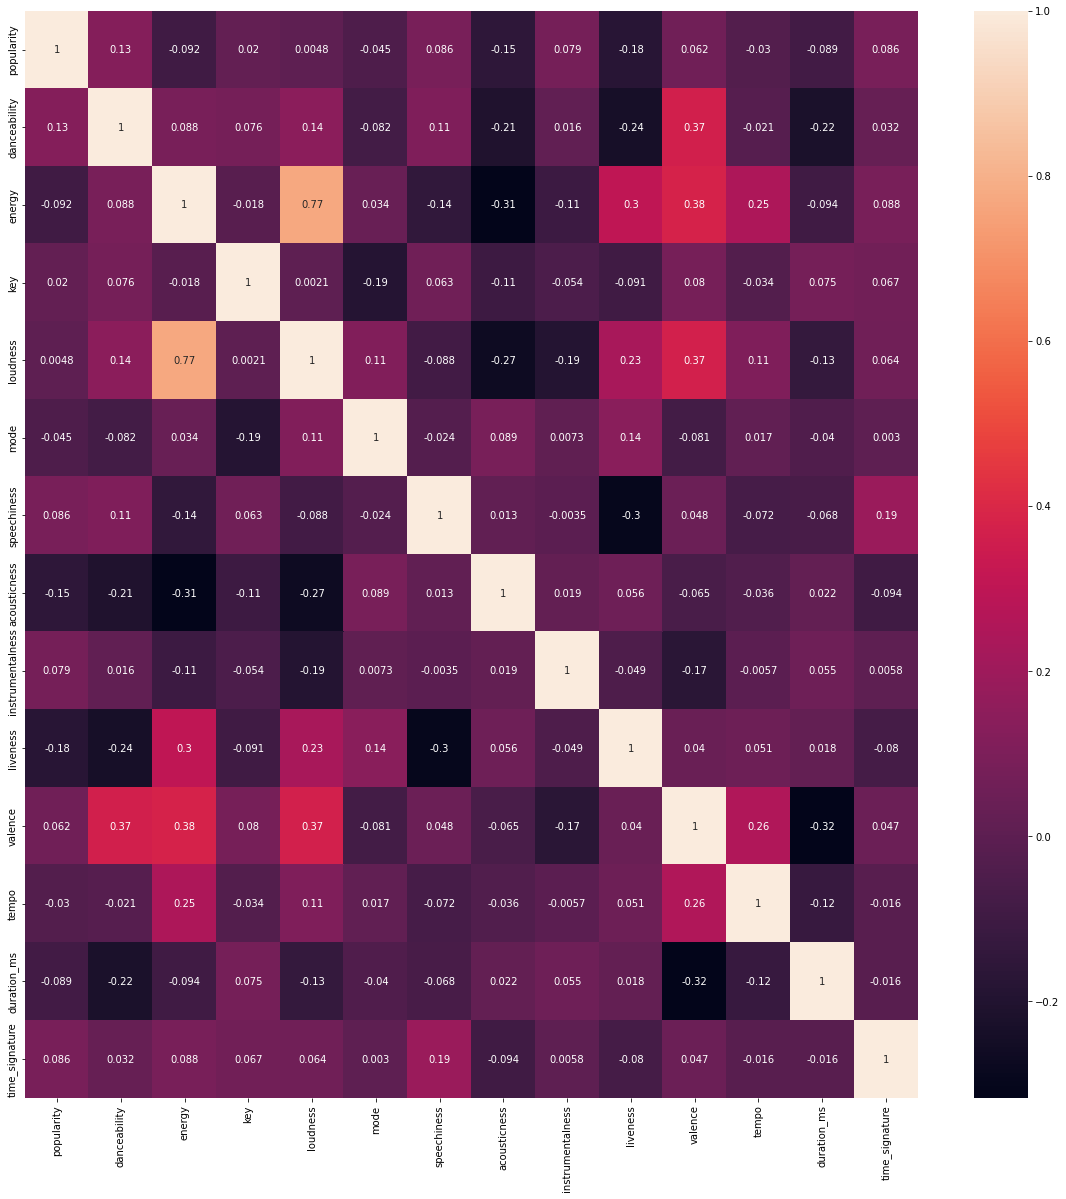

In [ ]:
plt.figure(figsize=(20,20))

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

plt.show()